In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import gpytorch

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
-0.7469609975297399
-0.7470224555156478
-0.7470839230886082
-0.7471453973375372
-0.7472068782604778
-0.7472683658554723
-0.7473298697356776
-0.7473913802780062
-0.7474528974804572
-0.7475144241854299
-0.7475759642980758
-0.7476375042885921
-0.7476990576911541
-0.7477606205532507
-0.7478221968257691
-0.747883779732176
-0.7479453788556502
-0.7480069778071852
-0.7480685969717009
-0.7481302091558588
-0.748191851139099
-0.7482534929274125
-0.7483151413228426
-0.7483768058875814
-0.7484384838746598
-0.7485001684649223
-0.7485618528220707
-0.7486235669986342
-0.748685280931703
-0.7487470109995891
-0.7488087544989489
-0.748870495044415
-0.7489322612550787
-0.7489940245073544
-0.7490558107394254
-0.7491175966788225
-0.7491794055901351
-0.7492412210710774
-0.749303050005172
-0.7493648786227788
-0.7494267302111234
-0.7494885883625281
-0.7495504530746528
-0.

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


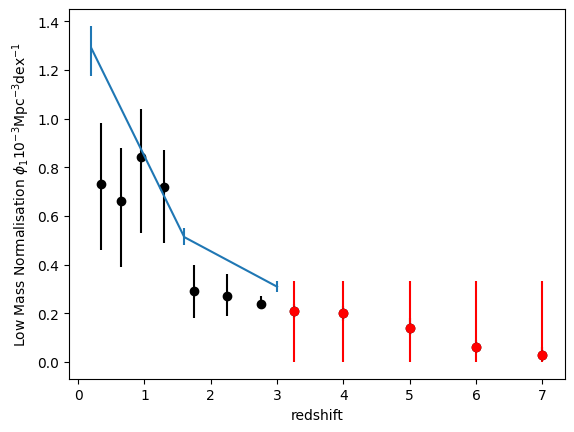

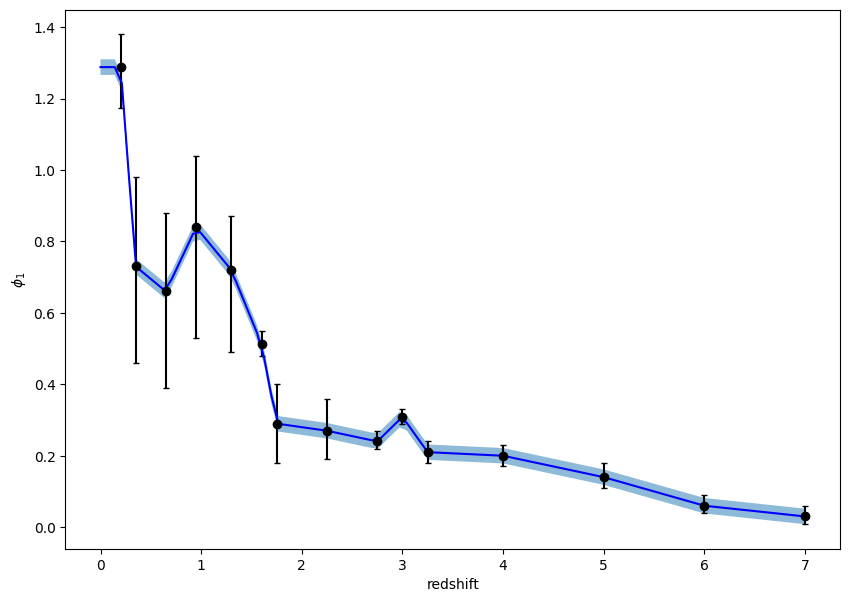

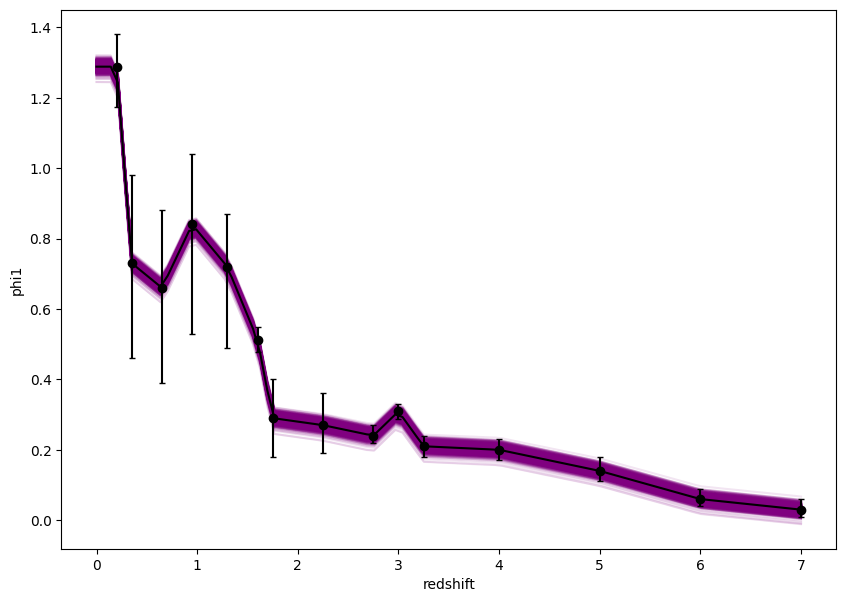

In [8]:
def propagate_cont_error(val, err):
    return abs(val)*abs(np.log(10)*err)

#assumption: declining normalisations with redshift
#little data above z>3, need to be open to having more galaxies at higher redshift due to results from jwst
#lhood or just use mean? if lhood, what width?? maybe just mean, assume small intrinsic scatter
#means are made up, problem?maybe using existing weaver points as mean...
#if have a gp for each, miss correlations between schecter parameters...

weaver_low_mass_norm_val = np.array([0.73, 0.66, 0.84, 0.72, 0.29, 0.27, 0.24, 0.21, 0.20, 0.14, 0.06, 0.03])
weaver_low_mass_norm_errl = np.array([0.27, 0.27, 0.31, 0.23, 0.11, 0.08, 0.02, 0.03, 0.03, 0.03, 0.02, 0.02])
weaver_low_mass_norm_errh = np.array([0.25, 0.22, 0.20, 0.15, 0.11, 0.09, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03])
weaver_redshift_lower_bin_edge = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5])
weaver_redshift_upper_bin_edge = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5, 7.5])
weaver_redshift_midpoint = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2
plt.errorbar(weaver_redshift_midpoint, weaver_low_mass_norm_val, yerr=[weaver_low_mass_norm_errl, weaver_low_mass_norm_errh], fmt='ko')

log_cont_low_mass_norm_val = np.array([-2.89, -3.29, -3.51])
cont_low_mass_norm_val = (10**log_cont_low_mass_norm_val)*1000
cont_low_mass_norm_log_errl = np.array([0.04, 0.03, 0.03])
cont_low_mass_norm_log_errh = np.array([0.03, 0.03, 0.03])
cont_low_mass_norm_errl = cont_low_mass_norm_val - (10**(log_cont_low_mass_norm_val - cont_low_mass_norm_log_errl))*1000
cont_low_mass_norm_errh = (10**(log_cont_low_mass_norm_val + cont_low_mass_norm_log_errh))*1000 - cont_low_mass_norm_val
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

plt.errorbar(cont_redshift_anchor_points, cont_low_mass_norm_val, yerr=[cont_low_mass_norm_errl, cont_low_mass_norm_errh])

zg3_index = np.where(weaver_redshift_midpoint>3.0)[0]
zg3_redshifts = weaver_redshift_midpoint[zg3_index]
highz_low_mass_norm_val = weaver_low_mass_norm_val[zg3_index]
highz_low_mass_norm_errl = weaver_low_mass_norm_val[zg3_index]
high_zlow_mass_norm_errh = (cont_low_mass_norm_errh[-1] + cont_low_mass_norm_val[-1] - weaver_low_mass_norm_val[zg3_index])

plt.errorbar(zg3_redshifts, highz_low_mass_norm_val, yerr=[highz_low_mass_norm_errl, high_zlow_mass_norm_errh], fmt='ro')


plt.ylabel("Low Mass Normalisation $\phi_{1} 10^{-3}\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}$")
plt.xlabel("redshift")

train_phi1 = torch.from_numpy(np.concatenate((weaver_low_mass_norm_val, cont_low_mass_norm_val)))
train_phi1_errl = torch.from_numpy(np.concatenate((weaver_low_mass_norm_errl, cont_low_mass_norm_errl)))
train_phi1_errh = torch.from_numpy(np.concatenate((weaver_low_mass_norm_errh, cont_low_mass_norm_errh)))
train_phi_errs = train_phi1_errl + train_phi1_errh
train_redshift = torch.from_numpy(np.concatenate((weaver_redshift_midpoint, cont_redshift_anchor_points)))

sorted_redshift_inds = train_redshift.argsort()
sorted_train_phi1 = train_phi1[sorted_redshift_inds]
sorted_train_phi1_errl = train_phi1_errl[sorted_redshift_inds]
sorted_train_phi1_errh = train_phi1_errh[sorted_redshift_inds]
sorted_train_phi_errs = sorted_train_phi1_errl + sorted_train_phi1_errh
sorted_train_redshift = train_redshift[sorted_redshift_inds]
mean = np.interp(np.linspace(0, 7.0, 100), sorted_train_redshift, sorted_train_phi1)

#plt.plot(np.linspace(0, 7.0, 100), mean)

class PHI1Model(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood):
        super(PHI1Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.GreaterThan(10.0)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.square(sorted_train_phi_errs), learn_additional_noise=False, noise_constraint=gpytorch.constraints.GreaterThan(0.0))
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.0))
model = PHI1Model(sorted_train_redshift, torch.zeros_like(sorted_train_redshift), likelihood)

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

training_iter = 10000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(sorted_train_redshift)
    # Calc loss and backprop gradients
    loss = -mll(output, torch.zeros_like(sorted_train_redshift))
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #i + 1, training_iter, loss.item(),
    print(loss.item())
        #model.likelihood.noise.item()
    #))
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 7.0, 100)

f_preds = model(test_x)
#y_preds = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_phi1.numpy(), yerr=[sorted_train_phi1_errl, sorted_train_phi1_errh], fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean + mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower+mean, upper+mean, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("redshift")
    ax.set_ylabel("$\phi_{1}$")

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 1000
    for sample in range(nsamples):
        f_sample = f_preds.sample()
        #if((f_sample > 0.0).all()):
        ax.plot(test_x, f_sample+mean, c='purple', alpha=0.1)
    ax.plot(test_x, f_preds.mean+mean, zorder=1000, ls='-', c='k')
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_phi1.numpy(), yerr=[sorted_train_phi1_errl, sorted_train_phi1_errh], fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("phi1")

(-0.2, 7.2)

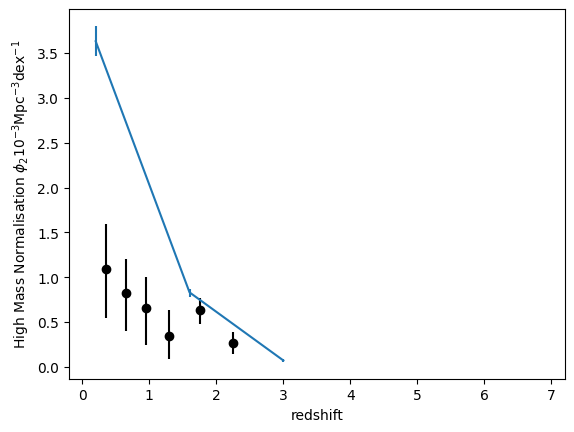

In [3]:
#it seems like weaver switiches to single shcecter function beyond z=3

weaver_high_mass_norm_val = np.array([1.09, 0.83, 0.66, 0.34, 0.64, 0.27])
weaver_high_mass_norm_errl = np.array([0.54, 0.43, 0.42, 0.25, 0.16, 0.12])
weaver_high_mass_norm_errh = np.array([0.5, 0.37, 0.34, 0.30, 0.13, 0.12])
weaver_redshift_lower_bin_edge_lowz = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0])
weaver_redshift_upper_bin_edge_lowz = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5])
weaver_redshift_midpoint_lowz = (weaver_redshift_lower_bin_edge_lowz + weaver_redshift_upper_bin_edge_lowz)/2
plt.errorbar(weaver_redshift_midpoint_lowz, weaver_high_mass_norm_val, yerr=[weaver_high_mass_norm_errl, weaver_high_mass_norm_errh], fmt='ko')

log_cont_high_mass_norm_val = np.array([-2.44, -3.08, -4.14])
cont_high_mass_norm_val = (10**log_cont_high_mass_norm_val)*1000
cont_high_mass_norm_log_errl = np.array([0.02, 0.03, 0.11])
cont_high_mass_norm_log_errh = np.array([0.02, 0.02, 0.10])
cont_high_mass_norm_errl = cont_high_mass_norm_val - (10**(log_cont_high_mass_norm_val - cont_high_mass_norm_log_errl))*1000
cont_high_mass_norm_errh = (10**(log_cont_high_mass_norm_val + cont_high_mass_norm_log_errh))*1000 - cont_high_mass_norm_val
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

plt.errorbar(cont_redshift_anchor_points, cont_high_mass_norm_val, yerr=[cont_high_mass_norm_errl, cont_high_mass_norm_errh])

plt.ylabel("High Mass Normalisation $\phi_{2} 10^{-3}\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}$")
plt.xlabel("redshift")
plt.xlim(-0.2, 7.2)

Text(0.5, 0, 'redshift')

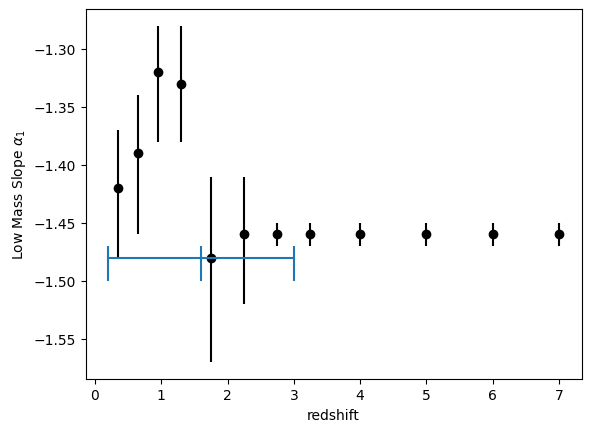

In [4]:
#slope fixed at z>2.5, error bars are place holders!!!!

weaver_alpha_low_mass_norm_val = np.array([-1.42, -1.39, -1.32, -1.33, -1.48, -1.46, -1.46, -1.46, -1.46, -1.46, -1.46, -1.46,])
weaver_alpha_low_mass_norm_errl = np.array([0.06, 0.07, 0.06, 0.05, 0.09, 0.06, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
weaver_alpha_low_mass_norm_errh = np.array([0.05, 0.05, 0.04, 0.05, 0.07, 0.05, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
weaver_redshift_lower_bin_edge = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5])
weaver_redshift_upper_bin_edge = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5, 7.5])
weaver_redshift_midpoint = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2
plt.errorbar(weaver_redshift_midpoint, weaver_alpha_low_mass_norm_val, yerr=[weaver_alpha_low_mass_norm_errl, weaver_alpha_low_mass_norm_errh], fmt='ko')

cont_alpha_low_mass_norm_val = np.array([-1.48, -1.48, -1.48])
cont_alpha_low_mass_norm_errl = np.array([0.02, 0.02, 0.02])
cont_alpha_low_mass_norm_errh = np.array([0.01, 0.01, 0.01])
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])
plt.errorbar(cont_redshift_anchor_points, cont_alpha_low_mass_norm_val, yerr=[cont_alpha_low_mass_norm_errl, cont_alpha_low_mass_norm_errh])

plt.ylabel("Low Mass Slope $\\alpha_{1}$")
plt.xlabel("redshift")


(-0.2, 7.2)

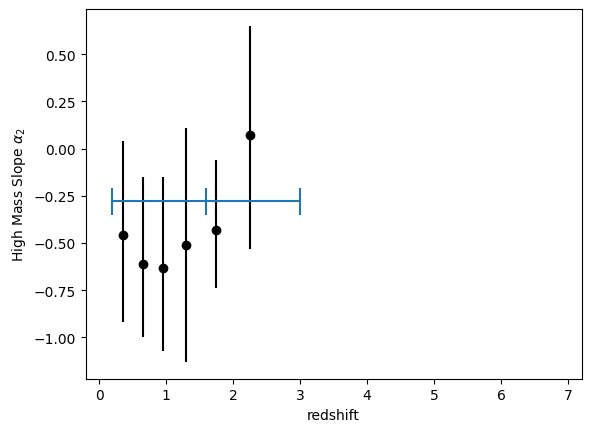

In [5]:
weaver_alpha_high_mass_norm_val = np.array([-0.46, -0.61, -0.63, -0.51, -0.43, 0.07])
weaver_alpha_high_mass_norm_errl = np.array([0.46, 0.39, 0.44, 0.62, 0.31, 0.60])
weaver_alpha_high_mass_norm_errh = np.array([0.5, 0.46, 0.48, 0.62, 0.37, 0.58])
weaver_redshift_lower_bin_edge_lowz = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0])
weaver_redshift_upper_bin_edge_lowz = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5])
weaver_redshift_midpoint_lowz = (weaver_redshift_lower_bin_edge_lowz + weaver_redshift_upper_bin_edge_lowz)/2
plt.errorbar(weaver_redshift_midpoint_lowz, weaver_alpha_high_mass_norm_val, yerr=[weaver_alpha_high_mass_norm_errl, weaver_alpha_high_mass_norm_errh], fmt='ko')


cont_alpha_high_mass_norm_val = np.array([-0.28, -0.28, -0.28])
cont_alpha_high_mass_norm_errl = np.array([0.07, 0.07, 0.07])
cont_alpha_high_mass_norm_errh = np.array([0.07, 0.07, 0.07])
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])
plt.errorbar(cont_redshift_anchor_points, cont_alpha_high_mass_norm_val, yerr=[cont_alpha_high_mass_norm_errl, cont_alpha_high_mass_norm_errh])

plt.ylabel("High Mass Slope $\\alpha_{2}$")
plt.xlabel("redshift")
plt.xlim(-0.2, 7.2)


Text(0.5, 0, 'redshift')

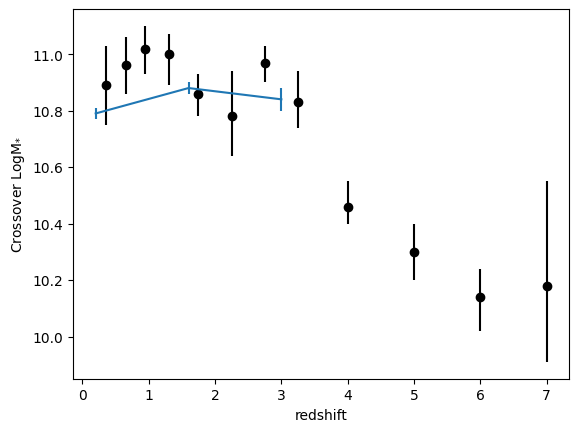

In [6]:
weaver_logm_val = np.array([10.89, 10.96, 11.02, 11.00, 10.86, 10.78, 10.97, 10.83, 10.46, 10.30, 10.14, 10.18])
weaver_logm_errl = np.array([0.14, 0.10, 0.09, 0.11, 0.08, 0.14, 0.07, 0.09, 0.06, 0.10, 0.12, 0.27])
weaver_logm_errh = np.array([0.14, 0.10, 0.08, 0.07, 0.07, 0.16, 0.06, 0.11, 0.09, 0.10, 0.10, 0.37])
weaver_redshift_lower_bin_edge = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5])
weaver_redshift_upper_bin_edge = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5, 7.5])
weaver_redshift_midpoint = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2
plt.errorbar(weaver_redshift_midpoint, weaver_logm_val, yerr=[weaver_logm_errl, weaver_logm_errh], fmt='ko')

cont_logm_val = np.array([10.79, 10.88, 10.84])
cont_logm_errl = np.array([0.02, 0.02, 0.04])
cont_logm_errh = np.array([0.02, 0.02, 0.04])
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])
plt.errorbar(cont_redshift_anchor_points, cont_logm_val, yerr=[cont_logm_errl, cont_logm_errh])

plt.ylabel("Crossover $\mathrm{LogM}_{*}$")
plt.xlabel("redshift")